In [6]:
from scipy.io import mmread
import os
import pandas as pd
import hdbscan
import numpy as np
from faerun import Faerun
import tmap as tm
import anndata
import scanpy as sc

#Alevin scRNA-seq quantification
in_scrna_dir = "/fast_dir/seq_data/alignment_out/pbmc/alevin/"
in_scrna_cols = "quants_mat_cols.txt"
in_scrna_rows = "quants_mat_rows.txt"
in_scrna_raw = "quants_mat.mtx.gz"
col_sel = 0
row_sel = 0
transpose = False
run_name = "healthy_pbc_alevin"

#STAR scRNA-seq quantification
in_scrna_dir = "/input_dir/crispr_analysis/alignment_out/pbmc/donor_1_1_star/Solo.out/Gene/filtered"
in_scrna_cols = "barcodes.tsv" 
in_scrna_rows = "features.tsv"
in_scrna_raw= "matrix.mtx"
col_sel = 0
row_sel = 1
transpose = True
run_name = "healthy_pbc_star"


In [7]:

#Read count MTX into array
scrna_data = mmread(os.path.join(in_scrna_dir, in_scrna_raw)).toarray()

#Read features (cols) and barcodes (rows)
scrna_cols = list()
with open(os.path.join(in_scrna_dir, in_scrna_cols)) as in_cols:
    for line in in_cols:
        arr = line.strip().split()
        scrna_cols.append(arr[col_sel])
scrna_rows = list()
with open(os.path.join(in_scrna_dir, in_scrna_rows)) as in_rows:
    for line in in_rows:
        arr = line.strip().split()
        scrna_rows.append(arr[row_sel])
    

In [8]:
scRNA_df = pd.DataFrame(data=scrna_data, index=scrna_rows, columns=scrna_cols)
if transpose:
    scRNA_df = scRNA_df.transpose()

In [9]:
#Make and annotate annData output
ann_scRNA = anndata.AnnData(scRNA_df)

#Cleanup data
ann_scRNA.var_names_make_unique()

#Filter genes and cells by few metrics
sc.pp.filter_cells(ann_scRNA, min_genes=200)
sc.pp.filter_genes(ann_scRNA, min_cells=3)

# add the total counts per cell as observations-annotation to ann_scRNA
ann_scRNA.obs['n_counts'] = ann_scRNA.X.sum(axis=1)
ann_scRNA.raw = sc.pp.log1p(ann_scRNA, copy=True)
sc.pp.normalize_per_cell(ann_scRNA, counts_per_cell_after=1e4)

#Filter genes by dispersion 
#filter_result = sc.pp.filter_genes_dispersion(ann_scRNA.X, min_mean=0.0125, max_mean=5, min_disp=0)
#sc.pl.filter_genes_dispersion(filter_result, show=False, save='dispersion.pdf')
#ann_scRNA = ann_scRNA[:, filter_result.gene_subset]
#Scale data
sc.pp.scale(ann_scRNA, max_value=10)
#Calculate nearest neighbors
sc.pp.neighbors(ann_scRNA, n_neighbors=10, n_pcs=10)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


         Falling back to preprocessing with `sc.pp.pca` and default params.


In [10]:
#Run TMAP dimensional reduction
DATA = pd.DataFrame(ann_scRNA.X, index=ann_scRNA.obs.index, columns=ann_scRNA.var.index)

# Initialize and configure tmap
dims = 2048
enc = tm.Minhash(len(DATA.columns), 42, dims)
lf = tm.LSHForest(dims * 2, 128, store=True)

fps = []
for _, row in DATA.iterrows():
    fps.append(tm.VectorFloat(list(row)))

lf.batch_add(enc.batch_from_weight_array(fps, method="I2CWS"))
lf.index()

# Configuration for the tmap layout
CFG_TMAP = tm.LayoutConfiguration()
CFG_TMAP.k = 50
CFG_TMAP.kc = 50
CFG_TMAP.node_size = 1 / 20

x, y, s, t, _ = tm.layout_from_lsh_forest(lf, CFG_TMAP)
lf.clear()


In [11]:
#Add TMAP embeddings to ann object
temp_df = pd.DataFrame.from_dict({"x":x, "y":y})
temp_df["CB"] = ann_scRNA.obs.index
temp_df = temp_df.set_index("CB")
ann_scRNA.obsm['X_tmap'] = np.array(temp_df)

#Call clusters using hdbscan
labels = hdbscan.HDBSCAN(
    min_samples=5,
    min_cluster_size=100,
).fit_predict(temp_df)
labels += 1

#add HDB labels to ann object
ann_scRNA.obs["hdbscan"] = labels
ann_scRNA.obs["hdbscan"] = ann_scRNA.obs["hdbscan"].astype("category")
#calculate marker genes based on clusters
sc.tl.rank_genes_groups(ann_scRNA, 'hdbscan', method='wilcoxon', max_iter=2000, use_raw=True)
#sc.pl.rank_genes_groups(ann_scRNA, n_genes=25, sharey=False)


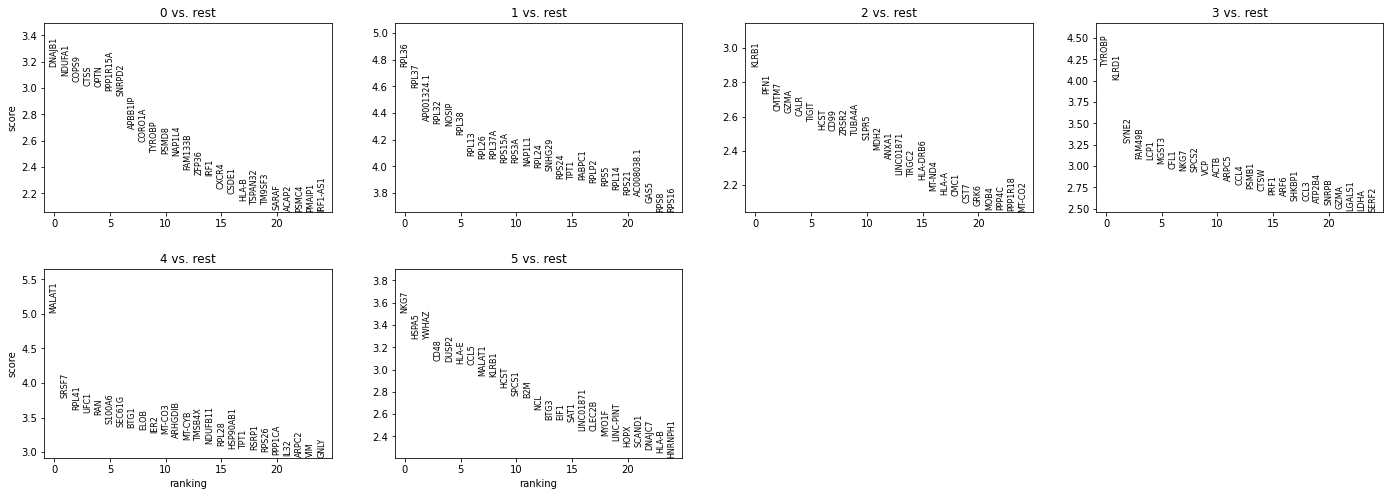

In [12]:
sc.pl.rank_genes_groups(ann_scRNA, n_genes=25, sharey=False)

In [14]:
#Add other dimensional reduction algorithms
sc.tl.umap(ann_scRNA)
sc.tl.leiden(ann_scRNA)
#sc.tl.rank_genes_groups(ann_scRNA, 'leiden', method='wilcoxon', max_iter=2000, dual=True, use_raw=True)
ann_scRNA.write_h5ad(f"scRNA_{run_name}_ann.h5ad")


In [15]:
crispr_loci = scRNA_df.loc[:,["CRISPR" in x for x in list(scRNA_df.columns)]]

In [16]:
crispr_loci.sum(axis=0)

Loci_hCRISPR1           0
Loci_hCRISPR3           4
Loci_hCRISPR2          13
Loci_hCRISPR2_TCRG    742
Loci_hCRISPR1_TCRB      8
dtype: int64

In [17]:

# Create the faerun plot
#Define cluster labels
legend_labels = {(0, "No cluster"), 
                 (1, "PBMC 1"),
                 (2, "PBMC 2"),
                 (3, "PBMC 3"),
                 (4, "PBMC 4"),
                 (5, "PBMC 5"),
                 (6, "PBMC 6"),
                 (7, "PBMC 7"),
                 (8, "PBMC 8"),
                 (9, "PBMC 9")}
faerun = Faerun(view="front", coords=False, legend_title="")
faerun.add_scatter(
    "RNASEQ",
    {"x": x, "y": y, "c": labels, "labels": labels},
    colormap="tab20",
    point_scale=5.0,
    max_point_size=10,
    shader="smoothCircle",
    has_legend=True,
    categorical=True,
    legend_labels=legend_labels,
    legend_title="Cell types",
)
faerun.add_tree(
    "RNASEQ_tree", {"from": s, "to": t}, point_helper="RNASEQ", color="#666666"
)
faerun.plot("rnaseq")


/input_dir/corona_analysis/EuCovid-2020/AlignmentAnalyzerImg/rnaseq.html

## Launch cellxgene to visualize results

In [18]:
%%bash

#Launch cellxgene to visualize results
cd /input_dir/corona_analysis/EuCovid-2020/AlignmentAnalyzerImg/
cellxgene launch --host 0.0.0.0 -p 5000 scRNA_healthy_pbc_alevin_ann.h5ad


bash: line 4: cellxgene: command not found


CalledProcessError: Command 'b'\n#Launch cellxgene to visualize results\ncd /input_dir/corona_analysis/EuCovid-2020/AlignmentAnalyzerImg/\ncellxgene launch --host 0.0.0.0 -p 5000 scRNA_healthy_pbc_alevin_ann.h5ad\n'' returned non-zero exit status 127.